# Imports

In [ ]:
import numpy as np
import pandas as pd # 1.1
from sklearn.preprocessing import StandardScaler # 1.2
from sklearn.model_selection import train_test_split # 1.4

# 1. Data Preprocessing

## 1.1 Get Data

### Player Data

In [ ]:
player_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/nba_players.csv'
player_df = pd.read_csv(player_data_url)
player_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,mathcup,gamedate,winloss,minuters,pts,fgm,...,dreb,reb,ast,stl,blk,tov,pfo,plusminus,fp1,player
0,1710822472-1,https://www.nba.com/stats/players/boxscores,NaN,ATL,ATL @ LAL,03/18/2024,NaN,13,8,4,...,4,8,0,1,1,1,1,-7,22.6,Clint Capela
1,1710822472-2,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,19,8,3,...,3,4,3,2,2,1,2,-1,28.3,Mo Bamba
2,1710822472-3,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,16,11,4,...,1,2,1,1,1,0,1,1,20.9,Thomas Bryant
3,1710822472-4,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,32,20,8,...,10,13,6,0,0,4,1,-19,40.6,Bam Adebayo
4,1710822472-5,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,24,12,4,...,1,2,1,0,1,1,1,11,17.9,Buddy Hield


In [ ]:
player_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'mathcup', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'fp1', 'player'],
      dtype='object')

In [ ]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage', 'fp1']
player_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
player_df['gamedate'] = pd.to_datetime(player_df['gamedate'])
player_df = player_df[player_df['gamedate'] != '2024-03-18']

# NBA made a typo so we gotta fix that
player_df['matchup'] = player_df['mathcup']
player_df.drop(columns=['mathcup'], inplace=True)

In [ ]:
def calculate_fantasy_points(row):
    # Points scored
    points_scored = row['pts'] * 0.5
    # Rebounds, Assists, Steals, and Blocks
    rebound_points = (row['oreb'] + row['dreb']) * 1
    assist_points = row['ast'] * 1
    steal_points = row['stl'] * 2
    block_points = row['blk'] * 2
    # Turnovers
    turnover_points = row['tov'] * -1
    # Three-points made
    three_points = row['3pm'] * 0.5
    # Double-Double and Triple-Double
    double_digits = sum(i >= 10 for i in [row['pts'], row['oreb'] + row['dreb'], row['ast'], row['stl'], row['blk']])
    double_double_points = 1.0 if double_digits >= 2 else 0
    triple_double_points = 2.0 if double_digits >= 3 else 0
    # 40+ and 50+ bonuses
    fourty_pt_bonus = 2.0 * (row['pts'] >= 40)
    fifty_pt_bonus = 2.0 * (row['pts'] >= 50)
    # Total fantasy points
    total_points = (points_scored + rebound_points + assist_points +
                    steal_points + block_points + turnover_points + three_points +
                    double_double_points + triple_double_points +
                    fourty_pt_bonus + fifty_pt_bonus)
    return total_points

In [ ]:
def get_opp_team(matchup):
    if '@' in matchup:
        return matchup.split(' @ ')[1]
    elif 'vs.' in matchup:
        return matchup.split(' vs. ')[1]
    else:
        return None

In [ ]:
# Helper function to determine home and away teams
def extract_teams(matchup):
    teams_a = matchup.split(' @ ')
    teams_h = matchup.split(' vs. ')
    if '@' in matchup:
        return teams_a[1], teams_a[0]
    else:
        return teams_h[0], teams_h[1]

# Function to create game_id
def create_game_id(row):
    home_team, away_team = extract_teams(row['matchup'])
    game_date = row['gamedate'].strftime('%Y-%m-%d')
    return f"{home_team}.{away_team}.{game_date}"

In [ ]:
player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L
player_df['fp'] = player_df.apply(calculate_fantasy_points, axis=1) # calculate fantasy points
player_df['opp_team'] = player_df['matchup'].apply(get_opp_team) # extract the opponent team name
player_df['game_id'] = player_df.apply(create_game_id, axis=1) # calculate the game id

# calculate how many days has passed since the start of the season till this game
season_start_date = pd.Timestamp('2023-10-24')
player_df['days_since'] = (player_df['gamedate'] - season_start_date).dt.days

player_df.head()

,team,gamedate,winloss,minuters,pts,fgm,fga,fgpercent,3pm,3pa,...,tov,pfo,plusminus,player,matchup,is_home,fp,opp_team,game_id,days_since
152,BOS,2024-03-17,1,35,14,6,15,40.0,2,5,...,1,0,16,Payton Pritchard,BOS @ WAS,0,28.0,WAS,WAS.BOS.2024-03-17,145
153,BOS,2024-03-17,1,23,9,3,7,42.9,3,6,...,0,0,7,Svi Mykhailiuk,BOS @ WAS,0,13.0,WAS,WAS.BOS.2024-03-17,145
154,BOS,2024-03-17,1,20,14,5,9,55.6,0,0,...,1,1,9,Luke Kornet,BOS @ WAS,0,17.0,WAS,WAS.BOS.2024-03-17,145
155,WAS,2024-03-17,0,22,8,4,7,57.1,0,2,...,0,3,-17,Johnny Davis,WAS vs. BOS,1,13.0,BOS,WAS.BOS.2024-03-17,145
156,WAS,2024-03-17,0,15,0,0,1,0.0,0,1,...,1,2,-14,Eugene Omoruyi,WAS vs. BOS,1,3.0,BOS,WAS.BOS.2024-03-17,145


In [ ]:
player_df.columns

Index(['team', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'player', 'matchup', 'is_home', 'fp', 'opp_team', 'game_id',
       'days_since'],
      dtype='object')

### Team Data

In [ ]:
team_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/teamscores.csv'
team_df = pd.read_csv(team_data_url)

In [ ]:
team_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,matchup,date,winloss,min,pts,fgm,...,ftpercent,oreb,dreb,reb,ast,stl,blk,tov,pfidk,plusminus
0,1710880555-1,https://www.nba.com/stats/teams/boxscores,NaN,CLE,CLE @ IND,03/18/2024,W,240,108,38,...,71.4,9,30,39,27,8,4,14,18,5
1,1710880555-2,https://www.nba.com/stats/teams/boxscores,NaN,IND,IND vs. CLE,03/18/2024,L,240,103,42,...,62.5,14,31,45,28,8,3,11,24,-5
2,1710880555-3,https://www.nba.com/stats/teams/boxscores,NaN,DET,DET @ BOS,03/18/2024,L,240,94,36,...,86.7,8,35,43,21,6,3,13,15,-25
3,1710880555-4,https://www.nba.com/stats/teams/boxscores,NaN,BOS,BOS vs. DET,03/18/2024,W,240,119,43,...,84.6,15,38,53,30,8,8,11,9,25
4,1710880555-5,https://www.nba.com/stats/teams/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,240,98,37,...,91.7,7,39,46,23,7,12,12,16,7


In [ ]:
team_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'matchup', 'date', 'winloss', 'min', 'pts', 'fgm', 'fga', 'fgpercent',
       '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'tov', 'pfidk', 'plusminus'],
      dtype='object')

In [ ]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage']
team_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
team_df['gamedate'] = pd.to_datetime(team_df['date'])
team_df = team_df[team_df['gamedate'] != '2024-03-18']

In [ ]:
team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
team_df['game_id'] = team_df.apply(create_game_id, axis=1)
team_df.head()

<ipython-input-15-a5d1a32ab59e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
<ipython-input-15-a5d1a32ab59e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
<ipython-input-15-a5d1a32ab59e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,team,matchup,date,winloss,min,pts,fgm,fga,fgpercent,3pm,...,ast,stl,blk,tov,pfidk,plusminus,gamedate,is_home,opp_team,game_id
16,LAC,LAC vs. ATL,03/17/2024,L,240,93,28,74,37.8,11,...,17,10,5,16,13,-17,2024-03-17,1,ATL,LAC.ATL.2024-03-17
17,ATL,ATL @ LAC,03/17/2024,W,240,110,41,84,48.8,17,...,32,10,7,16,22,17,2024-03-17,0,LAC,LAC.ATL.2024-03-17
18,BKN,BKN @ SAS,03/17/2024,L,265,115,47,102,46.1,8,...,29,13,5,12,20,-7,2024-03-17,0,SAS,SAS.BKN.2024-03-17
19,SAS,SAS vs. BKN,03/17/2024,W,265,122,46,99,46.5,9,...,30,6,10,18,17,7,2024-03-17,1,BKN,SAS.BKN.2024-03-17
20,ORL,ORL vs. TOR,03/17/2024,W,240,111,43,85,50.6,11,...,22,7,4,15,16,15,2024-03-17,1,TOR,ORL.TOR.2024-03-17


### Merging

In [ ]:
own_team_df = team_df.copy()
opp_team_df = team_df.copy()

In [ ]:
# renaming columns for the team data
team_rename_columns = {
    'pts': 'team_pts',
    'fgm': 'team_fgm',
    'fga': 'team_fga',
    'fgpercent': 'team_fgpercent',
    '3pm': 'team_3pm',
    '3pa': 'team_3pa',
    '3ppercent': 'team_3ppercent',
    'ftm': 'team_ftm',
    'fta': 'team_fta',
    'ftpercent': 'team_ftpercent',
    'oreb': 'team_oreb',
    'dreb': 'team_dreb',
    'reb': 'team_reb',
    'ast': 'team_ast',
    'stl': 'team_stl',
    'blk': 'team_blk',
    'tov': 'team_tov',
    'pfidk': 'team_pfidk',
    'plusminus': 'team_plusminus'
}

# renaming columns for the opponent team data
opp_rename_columns = {
    'pts': 'opp_pts',
    'fgm': 'opp_fgm',
    'fga': 'opp_fga',
    'fgpercent': 'opp_fgpercent',
    '3pm': 'opp_3pm',
    '3pa': 'opp_3pa',
    '3ppercent': 'opp_3ppercent',
    'ftm': 'opp_ftm',
    'fta': 'opp_fta',
    'ftpercent': 'opp_ftpercent',
    'oreb': 'opp_oreb',
    'dreb': 'opp_dreb',
    'reb': 'opp_reb',
    'ast': 'opp_ast',
    'stl': 'opp_stl',
    'blk': 'opp_blk',
    'tov': 'opp_tov',
    'pfidk': 'opp_pfidk',
    'plusminus': 'opp_plusminus'
}

own_team_df.rename(columns=team_rename_columns, inplace=True)
opp_team_df.rename(columns=opp_rename_columns, inplace=True)

In [ ]:
opp_team_df.columns

Index(['team', 'matchup', 'date', 'winloss', 'min', 'opp_pts', 'opp_fgm',
       'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent',
       'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb', 'opp_dreb',
       'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov', 'opp_pfidk',
       'opp_plusminus', 'gamedate', 'is_home', 'opp_team', 'game_id'],
      dtype='object')

In [ ]:
# merging player data with own team data
initial_merged_df = pd.merge(player_df, own_team_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from team_df that are redundant
initial_merged_df.drop([col for col in initial_merged_df.columns if 'drop' in col], axis=1, inplace=True)

# merging the last df with opponent team data
df = pd.merge(initial_merged_df, opp_team_df, left_on=['game_id', 'opp_team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from opp_team_df that are redundant
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)

In [ ]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'opp_team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'opp_team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_oreb,opp_dreb,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,10,30,40,24,3,5,16,20,-26,28.0
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,10,30,40,24,3,5,16,20,-26,13.0
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,10,30,40,24,3,5,16,20,-26,17.0
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,10,30,40,24,3,5,16,20,-26,29.0
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,10,30,40,24,3,5,16,20,-26,1.0


In [ ]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

## 1.2 Z-Score Normalization / Standardization

In [ ]:
"""
# Select the columns with player stats
stats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here

# Initialize the scaler
scaler = StandardScaler()

# Normalize the stats using Z-score normalization
df[stats_columns] = scaler.fit_transform(df[stats_columns])
"""

"\n# Select the columns with player stats\nstats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here\n\n# Initialize the scaler\nscaler = StandardScaler()\n\n# Normalize the stats using Z-score normalization\ndf[stats_columns] = scaler.fit_transform(df[stats_columns])\n"

## 1.3 One-Hot Encoding

In [ ]:
# one-hot encode the categorical columns
df = pd.get_dummies(df, columns=['opp_team'])

In [ ]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]

In [ ]:
df.head()

,player,team,gamedate,days_since,winloss,minuters,pts,fgm,fga,fgpercent,...,opp_team_ORL,opp_team_PHI,opp_team_PHX,opp_team_POR,opp_team_SAC,opp_team_SAS,opp_team_TOR,opp_team_UTA,opp_team_WAS,fp
0,Payton Pritchard,BOS,2024-03-17,145,1,35,14,6,15,40.0,...,False,False,False,False,False,False,False,False,True,28.0
1,Svi Mykhailiuk,BOS,2024-03-17,145,1,23,9,3,7,42.9,...,False,False,False,False,False,False,False,False,True,13.0
2,Luke Kornet,BOS,2024-03-17,145,1,20,14,5,9,55.6,...,False,False,False,False,False,False,False,False,True,17.0
3,Sam Hauser,BOS,2024-03-17,145,1,23,30,10,13,76.9,...,False,False,False,False,False,False,False,False,True,29.0
4,Neemias Queta,BOS,2024-03-17,145,1,8,0,0,0,-,...,False,False,False,False,False,False,False,False,True,1.0


In [ ]:
df.columns

Index(['player', 'team', 'gamedate', 'days_since', 'winloss', 'minuters',
       'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent', 'ftm',
       'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov',
       'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date', 'min',
       'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'opp_team_ATL', 'opp_team_BKN',
       'opp_team_BOS', 'opp_team_CHA', 'opp_team_CHI', 'opp_team_CLE',
       'opp_team_DAL', 'opp_team_DEN', 'opp_te

## 1.4 Train-Test Split

In [ ]:
# Split the data
X = df.drop(['fp'], axis=1)  # Features
y = df['fp']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

In [ ]:
import numpy as np

# Identify and print columns that are np.ndarrays with dtype 'object'
for column in df.columns:
    if isinstance(df[column].iloc[0], np.ndarray) and df[column].iloc[0].dtype == 'object':
        print(column)


for column in df.columns:
    if df[column].apply(lambda x: isinstance(x, np.ndarray)).any():
        unique_types = df[column].apply(type).unique()
        if len(unique_types) > 1 or unique_types[0] == np.object_:
            print(f"Column: {column}, Types: {unique_types}")


In [ ]:
from torch.utils.data import DataLoader, Dataset
class NBAFantasyDataset(Dataset):

    def __init__(self, dataframe):
        """
        dataframe: A DataFrame where each row is a game with columns for player details, game stats, and fantasy points ('fp').
        """
        self.data = dataframe
        # Sort the dataframe by 'gamedate' to ensure chronological order
        self.data.sort_values(by=['player', 'gamedate'], inplace=True)
        self.players = dataframe['player'].unique()

    def __len__(self):
        return len(self.players)

    def __getitem__(self, idx):
        player = self.players[idx]
        player_data = self.data[self.data['player'] == player]

        # Ensure there's at least five previous games to predict the next game
        if len(player_data) < 6:
            return None

        # Randomly select a game, excluding the first five games
        game_idx = np.random.randint(5, len(player_data))
        previous_games = player_data.iloc[:game_idx]
        target_game = player_data.iloc[game_idx]

        # Exclude non-numeric columns from features
        exclude_columns = ['player', 'team', 'gamedate', 'game_id', 'date', 'fp', 'matchup']
        features = previous_games.drop(columns=exclude_columns)

        # Replace non-numeric strings with NaN
        features = features.replace('-', np.nan)

        # Convert all values to floats
        features = features.astype(float)

        # Handle NaN values (e.g., fill with 0)
        features = np.nan_to_num(features)

        target = target_game['fp']

        return torch.tensor(features, dtype=torch.float), torch.tensor(target, dtype=torch.float)

In [ ]:
from torch.nn.utils.rnn import pad_sequence
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None

    features, targets = zip(*batch)

    # Pad the sequences to the same length
    padded_features = pad_sequence(features, batch_first=True)
    targets = torch.stack(targets)
    return padded_features, targets

# Update your DataLoader to use the new collate function
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

In [ ]:
dataset = NBAFantasyDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

In [ ]:
import torch

for i in range(5):
    sample = dataset[i]
    if sample is not None:
        features, target = sample
        print(f"Sample {i} - Features type: {type(features)}, Target type: {type(target)}")
    else:
        print(f"Sample {i} is None")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class BasketballRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BasketballRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)

        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Assuming the input size (number of features) is 79 as described in your input list
input_size = 92  # Number of input features
hidden_size = 128  # Number of hidden units in the RNN layer
num_layers = 2  # Number of stacked RNN layers
output_size = 1  # Predicting a single value (fp)

# Initialize the RNN model
model = BasketballRNN(input_size, hidden_size, num_layers, output_size)
print(model)

BasketballRNN(
  (rnn): RNN(92, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, num_epochs, learning_rate):
    # Move the model to the device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Loss function
    criterion = nn.MSELoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (features, targets) in enumerate(train_loader):
            # Move data to device
            features, targets = features.to(device), targets.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:  # Print loss every 100 batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Print average loss per epoch
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}')

    print("Training complete.")

In [ ]:
num_epochs = 10  # Number of epochs for training
learning_rate = 0.001  # Learning rate

train_model(model, dataloader, num_epochs, learning_rate)

In [ ]:
def calculate_accuracy(model, data_loader, threshold=5.0):
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for features, targets in data_loader:
            features = features.to(next(model.parameters()).device)
            targets = targets.to(next(model.parameters()).device)

            predictions = model(features).view(-1)
            total += targets.size(0)

            # Count how many predictions fall within +/- threshold of the targets
            correct += torch.sum(torch.abs(predictions - targets) <= threshold)

    accuracy = correct / total
    return accuracy.item()  # Convert from tensor to a scalar

# Example usage:
threshold = 7.0  # Define a threshold
accuracy = calculate_accuracy(model, dataloader, threshold)
print(f'Accuracy: {accuracy:.2f}')


In [ ]:
def calculate_deviations(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    deviations = []
    actual_fps = []

    with torch.no_grad():
        for features, actual_fp in data_loader:
            features = features.to(next(model.parameters()).device)
            predictions = model(features).view(-1)
            deviation = torch.abs(predictions - actual_fp.to(predictions.device))

            deviations.extend(deviation.tolist())  # Store deviations
            actual_fps.extend(actual_fp.tolist())  # Store actual fantasy points

    return actual_fps, deviations

import numpy as np

def aggregate_deviations(actual_fps, deviations):
    # Bin actual fps and calculate mean deviation for each bin
    max_fp = max(actual_fps)
    bins = np.linspace(0, max_fp, num=20)  # Adjust the number of bins as needed
    binned_deviations = {bin_: [] for bin_ in bins}

    for actual_fp, deviation in zip(actual_fps, deviations):
        for bin_ in bins:
            if actual_fp <= bin_:
                binned_deviations[bin_].append(deviation)
                break

    # Calculate mean deviations for each bin
    mean_deviations = {bin_: np.mean(devs) if devs else 0 for bin_, devs in binned_deviations.items()}
    return mean_deviations

import matplotlib.pyplot as plt

def plot_deviations(mean_deviations):
    plt.figure(figsize=(10, 6))
    plt.plot(list(mean_deviations.keys()), list(mean_deviations.values()), marker='o')
    plt.xlabel('Actual Fantasy Points (fp)')
    plt.ylabel('Average Deviation')
    plt.title('Average Deviation from Actual fp')
    plt.grid(True)
    plt.show()



In [ ]:
actual_fps, deviations = calculate_deviations(model, dataloader)
mean_deviations = aggregate_deviations(actual_fps, deviations)
plot_deviations(mean_deviations)

## Transformer-based model

In [ ]:
class BasketballTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, nhead):
        super(BasketballTransformer, self).__init__()

        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        out = self.fc(x[:, -1, :])  # Assuming you want to use the last timestep's output for prediction
        return out

In [ ]:
def train__trans_model(model, train_loader, num_epochs, learning_rate):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            outputs = torch.squeeze(outputs)  # Squeeze the output to match target's shape
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}')

    print("Training complete.")

In [ ]:
num_epochs = 15  # Number of epochs for training
learning_rate = 0.01  # Learning rate
hidden_size = 256  # Number of hidden units in the RNN layer
num_layers = num_layers = 5  # Number of stacked RNN layers
output_size = 1  # Predicting a single value (fp)
nhead = 8



model = BasketballTransformer(input_size, hidden_size, num_layers, output_size, nhead)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [1/15] Average Loss: 110.4986


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [2/15] Average Loss: 90.4654


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [3/15] Average Loss: 99.6407


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [4/15] Average Loss: 93.3432


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [5/15] Average Loss: 95.2986


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [6/15] Average Loss: 88.6529


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [7/15] Average Loss: 103.6163


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [8/15] Average Loss: 93.0426


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [9/15] Average Loss: 93.1440


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [10/15] Average Loss: 109.2798


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [11/15] Average Loss: 86.1103


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [12/15] Average Loss: 89.8497


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [13/15] Average Loss: 109.6840


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [14/15] Average Loss: 92.1177


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [15/15] Average Loss: 95.8271
Training complete.


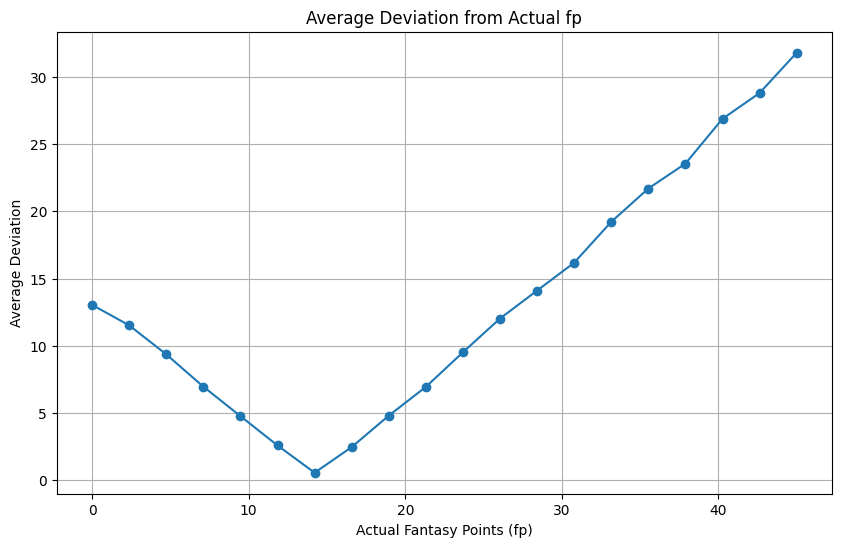

In [ ]:
train_model(model, dataloader, num_epochs, learning_rate)
actual_fps, deviations = calculate_deviations(model, dataloader)
mean_deviations = aggregate_deviations(actual_fps, deviations)
plot_deviations(mean_deviations)